### homework 2-1: Phoneme Classification

### some utilities

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

def plot_learning_curve(record, title='', mode='acc'):
  ''' plot learning curve of your DNN (train & validation loss/acc) '''
  
  if mode == 'acc':
    total_steps = len(record['train_acc'])
  else:
    total_steps = len(record['train_loss'])

  epochs = range(total_steps)
  
  figure(figsize=(5, 3))
  plt.xlabel('epoch')
  
  if mode == 'acc':
    plt.plot(epochs, record['train_acc'], c='tab:orange', label='train acc', linestyle='--')
    plt.plot(epochs, record['val_acc'], c='tab:blue', label='val acc', linestyle='--')
    plt.ylabel('accuracy')
  else:  
    plt.plot(epochs, record['train_loss'], c='tab:red', label='train loss', linestyle='--')
    plt.plot(epochs, record['val_loss'], c='tab:cyan', label='val loss', linestyle='--')
    plt.ylabel('loss')
  
  plt.title(f'{mode} curve of {title}')
  # use MaxNLocator to automatically adjust the x-axis ticks
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

  plt.legend()
  plt.show()

### download data
download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw2/data) <br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

### preparing data
load the training and testing data from the `.npy` file (numpy array)

In [2]:
import numpy as np

print('loading data ...')

data_root = './timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('size of training data: {}'.format(train.shape))
print('size of testing data: {}'.format(test.shape))

loading data ...
size of training data: (1229932, 429)
size of testing data: (451552, 429)


### create dataset

In [3]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
  def __init__(self, X, y=None):
    self.data = torch.from_numpy(X).float()
    if y is not None:
      y = y.astype(np.int64)
      self.label = torch.LongTensor(y)
    else:
      self.label = None

  def __getitem__(self, idx):
    if self.label is not None:
      return self.data[idx], self.label[idx]
    else:
      return self.data[idx]

  def __len__(self):
    return len(self.data)


split the labeled data into a training set and a validation set, <br>
you can modify the variable VAL_RATIO to change the ratio of validation data

In [4]:
VAL_RATIO = 0.2

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('size of training set: {}'.format(train_x.shape))
print('size of validation set: {}'.format(val_x.shape))

size of training set: (983945, 429)
size of validation set: (245987, 429)


create a data loader from the dataset, feel free to tweak the variable BATCH_SIZE here

In [5]:
BATCH_SIZE = 64

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, <br>
then you may remove this block or clean up unneeded variables later<br>
the data size is quite huge, so be aware of memory usage in colab**

In [ ]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

### create model

define model architecture, you are encouraged to change and experiment with the model architecture.

In [6]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(429, 1024),
      nn.BatchNorm1d(1024),  # add batch norm
      nn.Sigmoid(),
      nn.Dropout(0.1),       # add dropout

      nn.Linear(1024, 512),
      nn.BatchNorm1d(512),   # add batch norm
      nn.Sigmoid(),
      nn.Dropout(0.25),      # add dropout
      
      nn.Linear(512, 128),
      nn.BatchNorm1d(128),   # add batch norm
      nn.Sigmoid(),
      #nn.Dropout(0.25),      # add dropout
      nn.Linear(128, 39)
    )

  def forward(self, x):
    return self.model(x)

### training

In [7]:
# check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

fix random seeds for reproducibility

In [8]:
# fix random seed
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

feel free to change the training parameters here

In [9]:
# fix random seed for reproducibility
same_seeds(0)

# get device 
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 20               # number of training epoch
learning_rate = 0.0001       # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cpu


In [10]:
# start training

best_acc = 0.0
loss_acc_record = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}  # for recording loss/acc
for epoch in range(num_epoch):
  train_acc = 0.0
  train_loss = 0.0
  val_acc = 0.0
  val_loss = 0.0

  # training
  model.train()  # set the model to training mode
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    batch_loss = criterion(outputs, labels)
    _, train_pred = torch.max(outputs, 1)  # get the index of the class with the highest probability
    batch_loss.backward()
    optimizer.step()

    train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
    train_loss += batch_loss.item()

  # validation
  if len(val_set) > 0:
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
      for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, val_pred = torch.max(outputs, 1)

        val_acc += (val_pred.cpu() == labels.cpu()).sum().item()  # get the index of the class with the highest probability
        val_loss += batch_loss.item()
      
      train_acc_avg = train_acc / len(train_set)
      train_loss_avg = train_loss / len(train_loader)
      val_acc_avg = val_acc / len(val_set)
      val_loss_avg = val_loss / len(val_loader)

      loss_acc_record['train_acc'].append(train_acc_avg)
      loss_acc_record['train_loss'].append(train_loss_avg)
      loss_acc_record['val_acc'].append(val_acc_avg)
      loss_acc_record['val_loss'].append(val_loss_avg)
      
      print(f'[{epoch + 1:03d}/{num_epoch:03d}] Train Acc: {train_acc_avg:.6f} Loss: {train_loss_avg:.6f} | Val Acc: {val_acc_avg:.6f} loss: {val_loss_avg:.6f}')

      # if the model improves, save a checkpoint at this epoch
      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc / len(val_set)))
  else:
    print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
        epoch + 1, num_epoch, train_acc / len(train_set), train_loss / len(train_loader)
    ))

# if not validating, save the last epoch
if len(val_set) == 0:
  torch.save(model.state_dict(), model_path)
  print('saving model at last epoch')


[001/020] Train Acc: 0.457665 Loss: 1.904495 | Val Acc: 0.561883 loss: 1.466432
saving model with acc 0.562
[002/020] Train Acc: 0.547839 Loss: 1.497722 | Val Acc: 0.617146 loss: 1.256882
saving model with acc 0.617
[003/020] Train Acc: 0.584579 Loss: 1.359707 | Val Acc: 0.650079 loss: 1.135307
saving model with acc 0.650
[004/020] Train Acc: 0.609139 Loss: 1.268394 | Val Acc: 0.669096 loss: 1.070084
saving model with acc 0.669
[005/020] Train Acc: 0.626303 Loss: 1.202688 | Val Acc: 0.681020 loss: 1.017064
saving model with acc 0.681
[006/020] Train Acc: 0.639072 Loss: 1.153833 | Val Acc: 0.691004 loss: 0.978325
saving model with acc 0.691
[007/020] Train Acc: 0.649700 Loss: 1.115279 | Val Acc: 0.697899 loss: 0.951874
saving model with acc 0.698
[008/020] Train Acc: 0.657930 Loss: 1.082952 | Val Acc: 0.702212 loss: 0.931312
saving model with acc 0.702
[009/020] Train Acc: 0.665533 Loss: 1.055931 | Val Acc: 0.707777 loss: 0.911041
saving model with acc 0.708
[010/020] Train Acc: 0.67190

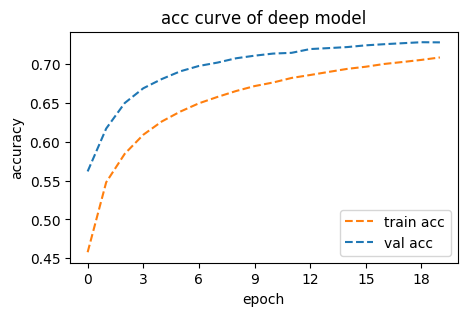

In [11]:
plot_learning_curve(loss_acc_record, title='deep model', mode='acc')

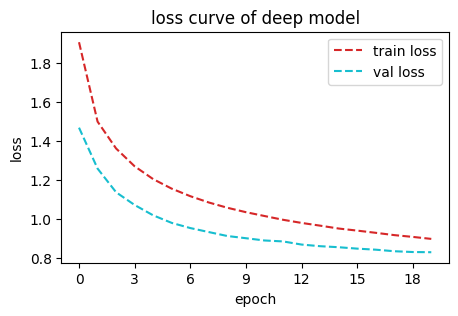

In [12]:
plot_learning_curve(loss_acc_record, title='deep model', mode='loss')

### testing
create a testing dataset, and load model from the saved checkpoint

In [13]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, weights_only=False))

<All keys matched successfully>

make prediction

In [14]:
predict = []
model.eval()  # set the model to evaluation mode
with torch.no_grad():
  for i, data in enumerate(test_loader):
    inputs = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1)  # get the index of the class with the highest probability
    
    for y in test_pred.cpu().numpy():
      predict.append(y)

write prediction to a CSV file

after finish running this block, download the file pred.csv from the files section on the left-hand side and submit it to [Kaggle](https://www.kaggle.com/c/ml2021spring-hw2/)

In [15]:
file = 'pred.csv'
print('saving results to {}'.format(file))
with open(file, 'w') as f:
  f.write('id,class\n')
  for i, y in enumerate(predict):
    f.write('{},{}\n'.format(i, y))

print('done!')

saving results to pred.csv
done!


the model with a simple baseline shows signs of overfitting. The training accuracy (train_acc) continues to improve, and at first, it is less than the validation accuracy (val_acc), but it eventually surpasses it. However, the validation accuracy increases slowly and even starts to decline in the last few epoch

After adding batch normalization and dropout, the validation accuracy (val_acc) improved by approximately 3%

From the previous accuracy and loss figures, it can be seen that the validation accuracy (val_acc) still shows a declining trend, so I will try increasing the number of epochs